# Deep Learning @ UWr 2021

**Lecture 03**

During lecture 2 we have seen that deep neural networks can be seen to generalize regression models: they introduce trainable feature extractors (the units in the hidden layers) that feed transformed data to the last layer which looks like a regression model. However, the addition of even a single hidden layer drastically changes the solutions one can achieve:
- a neural network with 2 layers (one hidden and one output layer) can approximate any well-behaving real-valued function (the universal approximation property)
- we pay for this increased representation power with having to solve a much optimization task: the neural network loss is not convex and has many local (and many global minimas).

However, deep neural networks are usually optimised using numerical optimzation techniques, most importantly using gradient based techniques. In lecture 2 we have seen how one can implement algorithms for gradient evaluation in deep models. In this lecture, we will look at practical aspects of fitting neural networks to data. Combined with the next lecture, our attack plan on deep learning is:
1. understand the implications of adding depth, properly (in the sense of returining correct loss values and gradients) implement a deep neural net [last lecture]
2. be able to choose training parameters in a way which allows reliable fitting of networks to data [this lecture]
3. ensure generalization through network regularization [next lecture].



## Function fitting

A deep neural network implements a differantiable (almost everywhere) mapping of a training sample $x$ to an output $y$. The mapping also depends on many parameters, (mainly the weights and biases of all neurons) collectively denoted $\theta$:

$$
y = f_{net}(x; \theta)
$$

The network is fitted to data by setting its parameters. The quality of the fit is usually measured using a loss function $l$, and we want the loss to be low **on the average**:

$$
\min_{\theta} \mathbb{E}_{x,y}\left[ l(F_{net}(x, \theta), y) \right]
$$

Computing this expectation requires summing over all possible input-output pairs $(x,y)$. This is not possible, and in practice we approximate the expectation on a sampled dataset (the training data) $\{(x^{(i)}, y^{(i)}): i=1,...,N\}$:

$$
\mathbb{E}_{x,y}\left[ l(F_{net}(x, \theta), y) \right] \approx \frac{1}{N}\sum_{i=1}^N l(F_{net}(x^{(i)}, \theta), y^{(i)})
$$

For instance, in a regression task we may choose to optimize the mean square loss
$$
L_{MSE}(\theta) = \frac{1}{N}\sum_{i=1}^N (F_{net}(x^{(i)}, \theta) - y^{(i)})^2
$$


Sometimes, regularization is used, which can be interpreted as adding an auziliary term $R$ to the loss function:

$$
L_R(\theta) =  \frac{1}{N}\sum_{i=1}^N l(F_{net}(x^{(i)}, \theta), y^{(i)}) + R(\theta)
$$

Our first (and honestly fairly trivial) observation is that practical training algorithm should somehow use tha fact, that the optimized loss function is in reality a large sum over independently sampled data points, plus the optional (and often simple) regularization term. 

### Gradient descent

The most basic function fitting algorithm is gradient descent: 

1. $\theta^{(0)} \gets \text{ an initial value}$
2. for $i=1,2,...$:

    1. $\theta^{(i)}\gets\theta^{(i-1)}-\alpha\frac{\partial L(\theta)}{\partial\theta}$

      where $\frac{\partial L(\theta, X, Y)}{\partial\theta}$ is evaluated ad $\theta^{(i-1)}$ and $\alpha$ is the step size, and $X, Y$ denote the full training set.

A few important observations about gradient descent (GD) are:
1. GD stops by itself: it searches for a stationary point (hopefully a local minimum, but could also end up in a saddle point). At convergence $\frac{\partial L(\theta)}{\partial\theta} = 0$
2. GD treats $L(\theta)$ as any other function: it needs to evaluate it and to compute its derivative, but it does not exploit its structure. The first consequence is that one step of gradient descent requires a fill pass over the dataset.

A cartoon depiction of gradient descent is pictured below: the algorithm makes steps towards the optimum, as we get nerer to it steps get smaller, because the gradient magnitude is smaller as well.

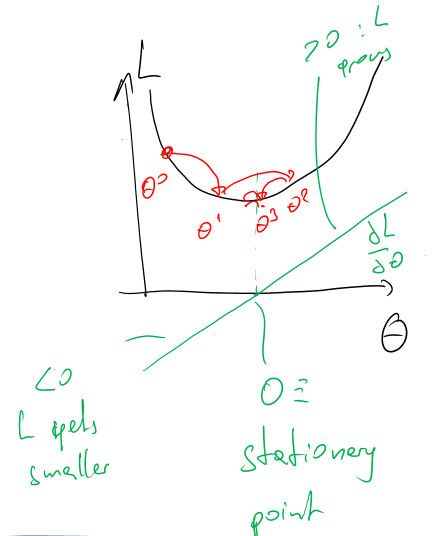

## Stochastic gradient descent

Gradient Descent doesn't exploit the structure of the loss function, and every step it takes requires computing the gradient on the full data set. This i sdifferent than e.g. the behavior of the perceptron learning machine, which updated its parameters after seeing each training example.

This behavior is implemented in the **Stochastic Gradient Descent** algorithm which updates the parameters besed on the gradient evaluated on a small subset of the training data (perhaps on one sample!):

1. $\theta^{(0)} \gets \text{ an initial value}$
2. for $i=1,2,...$:
    1. Sample $X_B, Y_B$ from $X, Y$

    1. $\theta^{(i)}\gets\theta^{(i-1)}-\alpha\frac{\partial L(\theta, X_B, Y_B)}{\partial\theta}$

      where $\frac{\partial L(\theta, X, Y)}{\partial\theta}$ is evaluated ad $\theta^{(i-1)}$, $\alpha$ is the step size, and $X_B, Y_B$ denote a small fraction of the training data, called a minibatch.

Why can we use minibatches $X_B, Y_B$ rather than the full training set? Recall, that we want to minimize the expected loss over the full data distribution:

$$
\mathbb{E}_{x,y}\left[ l(F_{net}(x, \theta), y) \right]
$$

We perform the minimzation using the derivative, which is a linear operator:
$$
\frac{\partial \mathbb{E}_{x,y}\left[ l(F_{net}(x, \theta), y) \right]}{\partial \theta}  = \mathbb{E}_{x,y}\left[ \frac{\partial l(F_{net}(x, \theta), y)}{\partial \theta} \right]
$$

The above relationship tells us, that we can approximate the gradient of the loss on sets of examples, simlilarly to how we have approximated the expected loss with the mean loss on the training set:

$$
\mathbb{E}_{x,y}\left[ \frac{\partial l(F_{net}(x, \theta), y)}{\partial \theta} \right] \approx \frac{1}{N_B} \sum_{x,y \in X_b, Y_B} \frac{\partial l(F_{net}(x, \theta), y)}{\partial \theta} = \frac{\partial L(\theta, X_B, Y_B)}{\partial\theta}
$$

All such approximations are noisy, but unbiased. These technical terms mean that:
1. This is just an approximation, $\frac{\partial \mathbb{E}_{x,y}\left[ l(F_{net}(x, \theta), y) \right]}{\partial \theta}  = \frac{\partial L(\theta, X_B, Y_B)}{\partial\theta} + \epsilon_{X_B, Y_B}$, where $\epsilon$ denotes the "noise" of the gradient estimation on the minibatch $X_B, Y_B$.
2. The noise has zero mean: $\mathbb{E}_{X_B,Y_B} \epsilon_{X_B, Y_B} = 0$ (this means that the estimator is unbiased, intuitively if we average many estimations, we get the true expected gradient).
3. The magnitude of the noise depends on the minibatch size. This will have implications on scaling the larning rates with changing batch size.

Thus, intuitively:
> SGD prefers to perform many noisy gradient applications, rather than few exact gradient applications.

A few important properties of SGD:
1. Iteration speed is decoupled from the dataset size, and depends on the minibatch size. (Note, that this doesn't neccessairly mean that the model will converge faster in the nuber of steps or walltime on larger datasets, it only means that the speed of applying updates is the same for small and large datasets).
2. The noise has to be accounted for:

    1. SGD does a random walk in the $\theta$ space. For instance, it never stops: even if the mean gradient on the full training data set is 0, the magnitude of gradients on the minibatch is governed by the noise magnitude.

    2. The noise will *regularize* the training process. Some intuitions come from:

        - simulated annealing - noise during training can help to escape poor local optimas

        - model robustness - if the model performs about the same in some vicinity of the optimal $\theta$ for the full training set, we hope it will generalize better (remmeber that full-train set GD also approximates the expected loss. In particular, the optimal $\theta$ for th etraining set is not th eoptimal $\theta$ for the test set, though we hope they are close and that the $\theta$ found during network training is lose to them as well).

    As Leon Bottou explained it: the noise in SGD is important, because it is the noise coming from unknown data, and generalizatoin requires us to work well on unknonwn data.

### SGD terminology

SGD training uses some new vocabulary:
- iteration means one training step
- minibatch is the data used for one iteration
- epoch is a full pass over training data. Typically during an epoch:
    1. data is shuffled
    2. minibatches are generated from the shuffled data (in this way each training smaple is used once during an epoch)
    3. training iterations are performed on each minibatch
- learning rate, or step size denotes the hyperparameter $\alpha$. It is often set according to a schedule, or based on validation results

### Step-size $\alpha$ in SGD

The learning rate $\alpha$ becimes a crucial hyperparameter in working with SGD:
1. Since by itself SGD will never "settle down", we reduce $\alpha$ to force convergence of the training process.
2. Since $\alpha$ controls the size of steps during a random-walk exploration of the $\theta$ space, we $\alpha$ controls the rate of space exploration. Thus, a larger $\alpha$ may lead to better solutions, and magnitude of $\alpha$ controls ont only the convergence speed but also regularization.

Because $\alpha$ is changed during the training run, we typically speak about _learning rate schedules_, rather than about _learning rates_.

The formal requirements on learning rate schedule are:
1. $\sum_t \alpha_t = \infty$ intuitively meaning that regardless of where we start the optimization, we can reach any value of $\theta$
2. $\sum_t \alpha_t^2 < \infty$ meaning that the process will converge.

A schedule fulfilling these requirements is e.g. $\alpha_t = \alpha_0\frac{1}{t}$.

In practice, SGD is  never run to convergence and many practically used learning rate schedules do not fulfill all of the above criteria:
- exponentially decaying schedule $\alpha_t = \alpha_0\beta^t$ with $\beta < 1$
- stepwise reductions of learning rate according to a fixed schedule (you will typically read in papers that e.g. the firs 100 epochs used a learning rate $\alpha$, which was then halved every 5 epochs)
-  sometimes, a warmup is apllied during which the learning rate grows to a predefined value, and only then is decayed (intuitively this serves as an extended network initialization period during which the neurons "learn" to work with each other)

Beause of the implications of the learnig rate both on model convergence and on the quality of the found optima, tuning it is important. Usual advice is that you should start with a learning rate which is 2-3 times smaller than one for which training diverges. Please note, that for compkex models this whould be determined after the initial warmup phase.

Some intuitions on the importance of learning rates can be seen in the figure below:

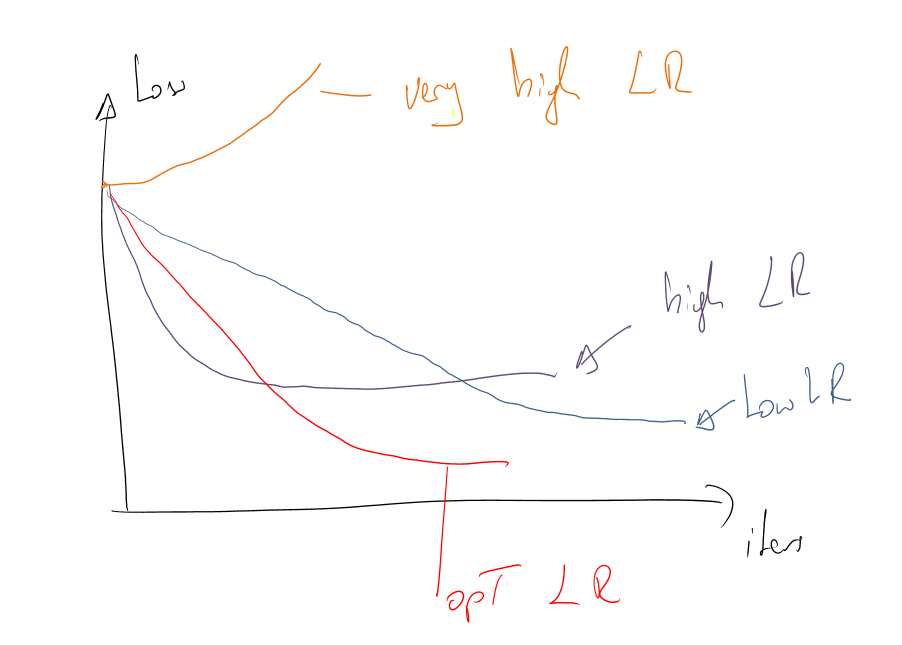

I typically like to start with the stepwise reduction of the learning rate, during which you start with a large learning rate, train until the loss plateaus, then reduce the learning rate, wait for another plateau and repeat:

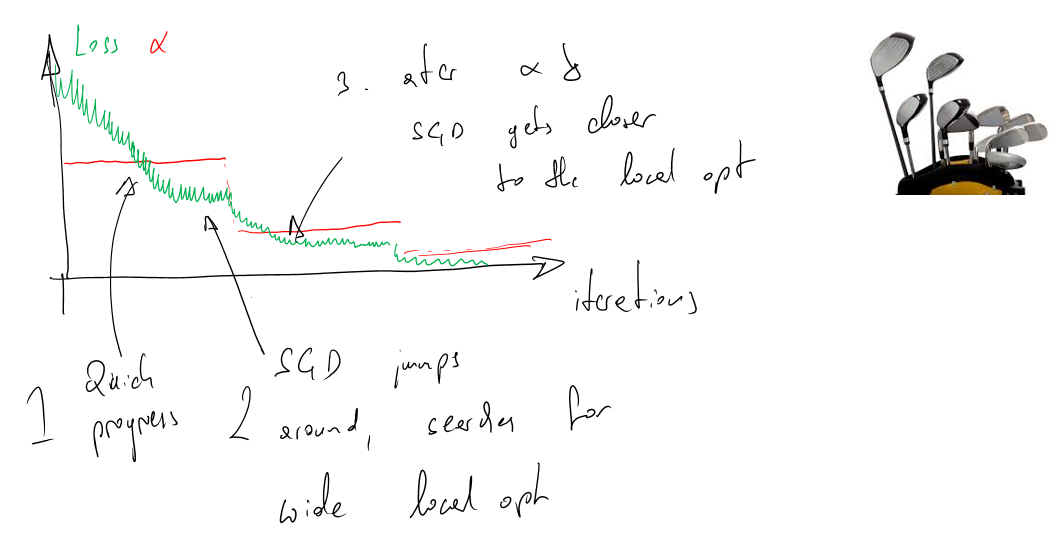

The intuition to this learnign rate schedule is similar to using different sizes of golf clubs: you use a large $\alpha$ to explore the parameter space and find a good basin of attraction. You then reduce it, to hone in on a (local) optimum.

The early training with a large $\alpha$ is important. The noise injected during the process ensures, that optimum found is _wide_ - the network performs similarly for all parameters $\theta + \epsilon$ in a neighborhood. This usually helps generalization. 

### More complex learning rate schedules

Some authors suggest to use several cycles during which the learning rate is decreased and increased. A nice description of the process is provided at https://arxiv.org/pdf/1506.01186.pdf. This sometimes helps the network to escape local optimas and saddle points. Moreover, one can use the parameters found at then end of the cycles to form a [snaphot ensemble](https://arxiv.org/pdf/1704.00109.pdf).

Also popular is the "one-cycle" schedule, during which there is a long warmup period, during which the learning rate is increased, follwed by a reduction a few orders of magnitude past the initial learning rate.

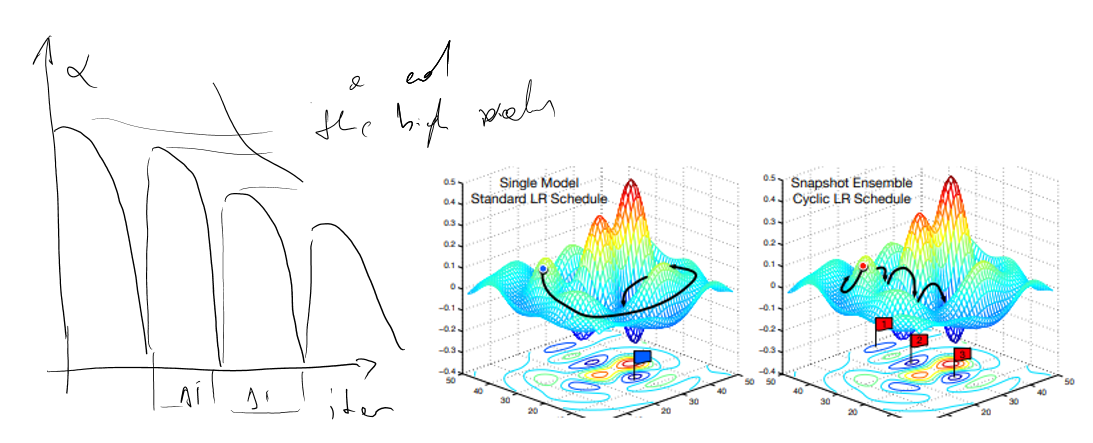

### Speeding up SGD with momentum

Consider minimizing the quadratic loss function whose contours are as follows:

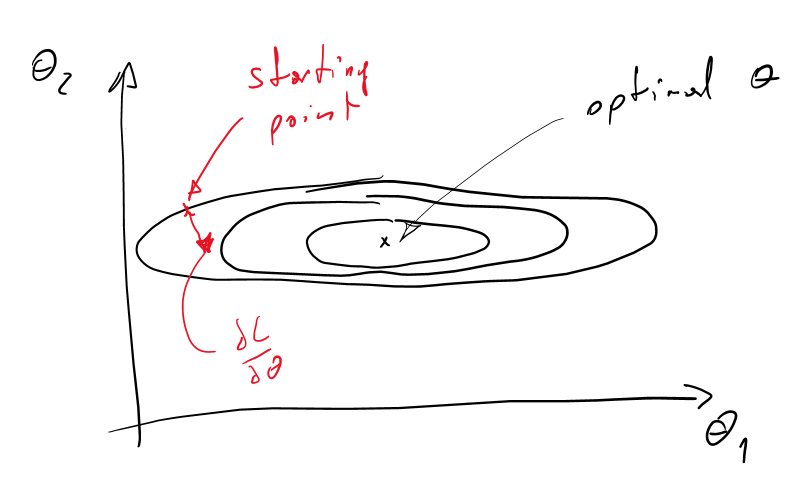

Notice how at the initial point the gradient (which is perpendicular to the contour lines) doesn't point direclty to the location of the optimum.

This causes problem to the learning proces:
- we need to move a lot on the $\theta_1$ axis, but $\frac{\partial L}{\partial\theta_1}$ is small, but
- we need to move only a little on the $\theta_2$ axis, but $\frac{\partial L}{\partial\theta_2}$ is large.

Thus we would want to have a large learning rate for $\theta_1$ and a small one for $\theta_2$. 

Classical optimization algorithms solve this by multiplying the gradient by the inverse of the Hessian (matrix of second derivatives), or by an approxmation to the Hessian. This is hard to achieve in neural networks, mainly for two reasons:
- the full Hessian is just too big
- second-order optimization is more useful in the large-batch cae, in minibatch SGD the noise term would make estiations of the Hessian ureliable.
- last but not least, neural network optimization loss is non-convex, and second order methods designed for convex optimizatoin may search wrong critical points (e.g. they may converge to [saddle points](https://arxiv.org/abs/1406.2572)).
Thus, while there is ongoing research on using the second-order information (e.g. the [Hessian-free optimizer](https://icml.cc/Conferences/2011/papers/532_icmlpaper.pdf) or [K-Fac](https://arxiv.org/abs/1503.05671), the most commonly used training algorithms try to equalize the learning rates using simpler approaches.

The momentum method is a particularly simple extension of SGD, which can dramatically improve convergence. To get intuitions, look at the gradients diring first few iterations of GD on the example above:


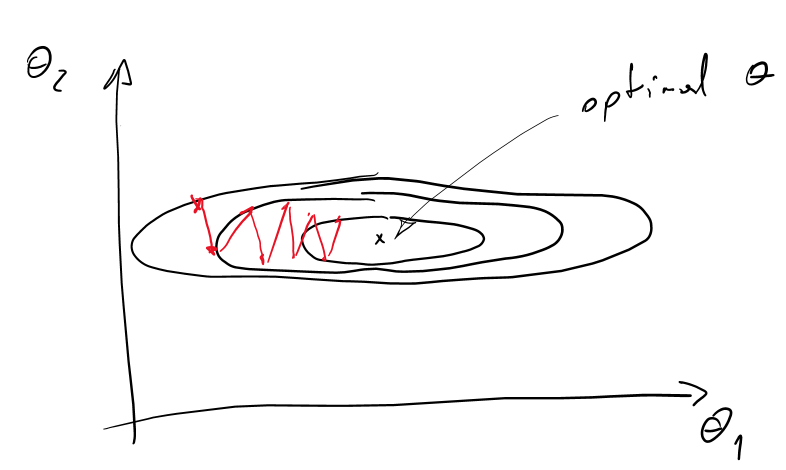

One can notice, that the average of the gradient of a few **consecutive steps** would have:
- a large component along the $\theta_1$ direction, as gradients on all steps consecutuvely point in that direction
- a smaller component along $\theta_2$ direction, because gradients on consecutive steps have opposing signs and cancel each other out in the average.

This is the main intuition behind the momentum method, which is typically implemented using the equations:
$$
\begin{split}
V^{(t)} &\gets \mu_t V^{(t-1)} - \alpha_t \frac{\partial L}{\partial \theta} \\
\theta^{(t)} &\gets \theta^{(t-1)} + V^{(t)}
\end{split}
$$

Momentum keeps an exponentially weighted average of past gradients in vairables $V^{(t)}$. These help to dmapen gradient oscillations due to:
- narrow and long ravines, as in the example above
- SGD noise between iterations.

Momentum is very popular, and often leads to improved modle convergence. However, it introduces a new hyperparameter, $\mu_t$ which often requires its own schedule.

A very similar (and theoretically proved to speed convergence) technique for convex optimization is the [Nesterov Accelerated Gradient](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.693.855) which is also sometimes used in neural network training.




### Neural networks are scale-dependent

One source of problems with training neural networks is the unequal magnitude of values that flow through it.

Neural networks implement non-linear mappings. Thus their output may change in a non-trivial way when their input is rescaled. 

Moreover the scale of values that flow through the network impacts training dynamics. As a case in point, consider the two models:
- Model M1 computes $O_1(x) = W_1 x$
- Model M2 computes $O_2(x) = \frac{1}{10}W_2 x$, with $W_1 = 10 W_1$.

Clearly, for any $x$ $O_1(x) = O_2(x)$. The two networks implement the same computation!

The derivatives of some loss with respect to $W_1$ and $W_2$ are very different:
- $\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial O_1} x$
- $\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial O_2} \frac{1}{10} x$

However, since $O_1(x) = O_2(x)$ we must have $\frac{\partial L}{\partial O_1} = \frac{\partial L}{\partial O_2}$! Thus:

$$
\frac{\partial L}{\partial W_1} = 10 \frac{\partial L}{\partial W_2}
$$

Lets summarizie what has happened:
- The two networks implement the same function
- $M_2$ divides its input by 10, then applies weights that are $10$ times larger.
- The derivatives of the loss with respect to $W_1$ and $W_2$ differ by a factor of 10.
- In SGD we update a parameter $p$ using $p \gets p - \alpha \frac{\partial L}{\partial p}$. The change introduced by a gradient step is dependent on the magnitude of the parameter and of the gradient!
- This ration is different 100x for the two networks: not only $W_2 = 10W_1$, but also $\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial W_1}/10$.

Thus a simple scaling of the input to a linear module, compensated by a change in the weights magnitude changes training dynamics. 

Now imagine a netowrk with ReLU units - We can imagine scaling by 10 weights in every second layer, and analogously scaling waights in remaining layers by 0.1. With proper handling of biases, this will not affect the function computed by the network. But the derives computed during the backward pass wil lbe different, and the two networks will train in a very different manner! The ReLU case was studied in the [PathSGD](https://papers.nips.cc/paper/2015/file/eaa32c96f620053cf442ad32258076b9-Paper.pdf) algorithm. Below we will introduce normalizatoin layers that provide another solution to scale dependence.

The take-home observations are that:
1. we must pay attention to the magnitude of weights and the magnitude of gradients in each layer, we want that the gradient updates are not too lare with comparison to weight magnitude but that they are not negligible either.
2. we must ensure that the scale of values that flow through the network is controlled. We do it using input normalization and careful weigth initialization.

### R-Prop and RMSProp

The impact of the magnitude of values that flow through the network on the magnitude of gradients computed during the backward pass has inspired training algorithms which disregarded the magnitude of the gradients, and relied only on their sign.

One such early algorithm was **RProp**, or resiloient back propagation. In RProp each weigth had its own learning rate. The learning rate was increased, if the sign of the gradient during consecutive updates was consistent, and reduced when the sign of the gradient was frequently changing. Thus the magnitude of the update depended only on the consistency of the sign of the gradient, and not on its magnitude. RProp worked well, but it required the gradient sto be fairly stable, and was really a batch-method.

RMSProp is an RProp-inspired training rule invented by Geoff Hinton. Just like in RProp, we want the updates to only depend on the sign of the gradients, ond not on their magnitude. However, we want that netowkr can be trained on minibatches, which means that the learning rule has to work in the presence of gradient fluctuations cause by minibatches.

Hinton's intuition was to use the fact that $\text{sign}(x) = \frac{x}{|x|}$. However, due to natural minibatch gradient fluctuations, the magnitude of the gradient is estimated using a running mean. Thus, RMSProp maintains a scale estimate $r$ for each trainable parameter. During the $t$-thraining step the updates are:
$$
\begin{split}
r^{(t)} &\gets (1-\gamma)\left( \frac{\partial L}{\partial \theta} \right)^2 + \gamma r^{(t-1)} \\
\theta^{(t)} &\gets \frac{\alpha^{(t)}}{\sqrt{r^{(t)} + \epsilon}} \frac{\partial L}{\partial \theta}
\end{split}
$$
where all operations are *elementwise*. Thus $\sqrt{r^{(t)} + \epsilon}$ is the estimate of the magnitude of gradient for each weigth. The hyperparameter $\epsilon$ is introduced to prevent a division by zero - it effectively clips the normalization.

RMSProp was very successful. One interpretation of its behavior is that it gives each weight its own learning rate, scaling down updates to weighs whose gradients are large.

### ADAM learnign rule

RMSProp normalizes the gradient by a running average of its magnitude. This speeds up trainingm because it equalizes the magnitude of the updates through the network. 

On the other hand, Momentum was designed to speed up training by killing gradient oscillations. 

The two mechanism can be combined. One very popular combination is dubbed [ADAM](https://arxiv.org/pdf/1412.6980.pdf):

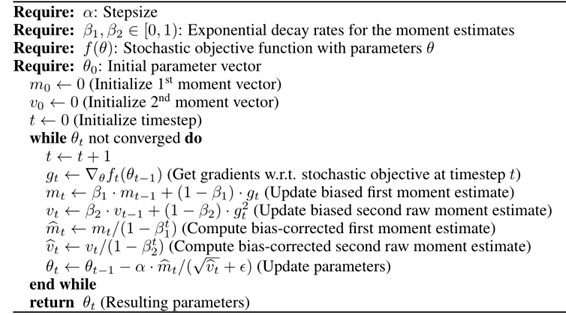

We can see that ADAM maintains two running means per parameter:
- $m_t$, the running mean of past gradients, i.e. the momentum term
- $v_t$, the running mean of past gradient squares, i.e. the RMSProp term

The bias-corrected quantities solve a technical prbem which happens during the first iterations: we often initialize $m_0=0, v_0=0$. Then, the two running means are close to 0 for the first few iterations. The debiasing term scales them up.

In overall, ADAM has 4 hyperparameters:
- learning rate $\alpha$, which often has to be tuned and which should have a schedule
- the integration timeconstants $\beta_1$ and $\beta_2$, which can usually be set to their default values (there were a few changes to the recommendations, PyTorch uses 0.9 and 0.999 respectively
- the $\epsilon$ constant which prevents division by zero. It's default value is $1e-8$ and sometimes has to be tuned (it should be smaller that the running mean of the gradient magnitudes).

ADAM is considered to be a safe default training algorithm and is widely used.

### Polyak weigth averaging

A final trick that often speeds up training consists of using a model whose parameters are the average of parameters from some past training iterations.

Please note, that this is not an ensemble of several models (where we have several models, put a test sample through all of them and average the results), but a different way to set the weigths of a _single_ model.

The intuition is that SGD is performing a random walk in the parameter space. Thus, when the model is close to convergence, the model roams the space around a central point to which it will eventually converge when the learning rate is sufficiently decayed. By taking the average (barycenter) of the parameters visited by the model, we may reach to optimal point faster.

Two weight averaging strategies are sometimes used:
1. one can try to average the parameters from some historical checkpoints
2. one can use _shadow parameters_ which are running means of regular model parameters:
  $$
  \begin{split}
    \theta^{(t)} &\gets \text{ regular parameter update} \\
    \theta_{P}^{(t)} &\gets \tau \theta_{P}^{(t-1)} + (1-\tau) \theta^{(t)} \\
    \end{split}
  $$

  with $\tau$ usually set to 0.99 or 0.999.

  Notice that the shadow parameters $\theta_P$ are not used to train the network, they simply track the normal parameters.

From my experience Polyak weight averaging can yield faster convergence, especially when the model is trained with a large learning rate. It is fairly cheap to test (the overhead of maintaining the shadow weights is usually small compoared to forward-backward pass over the network).

## Normalization of values that flow through a network

As we have seen, neural networks are sensitive to the magnitude of the values that flow through them and to the magnitude of their weigths.

There are several strategies to keep the magnitudes under control:
1. scale network inputs, and carefully initialize all parameters to maintain proper magnitude of inputs to each layer
2. introduce explicit scaling operations.

### Weight initialization

Assume a network with several hidden layers. The signal path is:

$$
x \rightarrow L_1 \rightarrow L_2 \rightarrow ... \rightarrow L_o
$$

that is, the inputs $x$ are fed to the first layer, which usually applies a matrix multiplication followed by a nonlinearity. The outputs of the first layer are fed to the second one, etc.

We would want that the inputs $x$ and outputs (after the non-linearity) of of each layer are standardized to have 0 mean and standard deviation 1.

We begin by normalizing the inputs, such that each feature has mean 0 and standard deviation 1. This is standard practice, already recommended for e.g. linear or logistic regression.

Now consider a matrix multiplication:

$$
o_j = \sum_{i=1}^n w_{ji} x_i
$$

After normalization, we can assume that across the dataset the $i$-th feature $x_i$ has mean 0, std 1.
The weigths are drawn i.i.d. from a distribution with mean 0 and standard deviation $\sigma$.

Thus each term $w_{ji} x_i$ has mean 0 and standard deviation $\sigma$. The mean of $o_j$ is then 0. The standard deviation of $o_j$ is:

$$
\text{stdev}(o_j) = \sqrt{n \text{stdev}(w_{ji} x_i)} = \sqrt{n \sigma^2} = \sqrt{n}\sigma
$$

Assume that the nonlinearity has a gain $g$. For instance, ReLU has an average gain $1/2$ (on the average half of the inputs to ReLU are below zero, and are zeroed, the other half are passed as is).

We want that $\text{stdev}(o_j) \cdot \sqrt{g} = 1$, where the square root over $g$ comes from the fact, that scaling a random variable by $g$ svales its _variance_ by $g$, thus scales its standard deviation by $\sqrt{g}$. This allows us to solve for $\sigma$:

$$
\sigma = \frac{1}{\sqrt{g\cdot n}}
$$

As a rule of thumb, you can remember that the standard deviation of weights shoudl be inversely proportional to the square root of $n$, or the fan-in (the number of inputs) to a neuron.

Similar considerations about the magnitude of gradients lead to the conclusion that the initial weight magnitude should also be proprtional to the square root of a neurons fan-out (the number of neurons to which it feeds its output). Thus typically, we use the average of the fan-in and fan-out of neurons inside a given layer.

The popular initialization rules follow this approach. In particular the so called [Xavier Glorot](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization samples the weights from a uniform distribution $\mathcal{U}(-a, a)$ with $a=\sqrt\frac{3}{g(\text{fan_in + fan_out})/2}$. Where the $3$ comes from the standard deviation of the uniform distribution. For ReLU units the [Kaiming He](https://arxiv.org/abs/1502.01852) initialization uses the ReLU gain.

#### Orthogonal initialization

We initialize neurons randomly to ensure that each neuron in a layer performs a different function. We call this "symmetry breaking". Sometimes, we want to force the neurons to perform different functions in a more explicit way.

One such approach is to peform an rtohogonal initialization - we initialize a weight matrix such that the vector of weights incoming to neurons $i$ and $j$ of the layer are orthogonal. One possible implementation is to start with a random matrix, which is then orthogonalized using e.g. the Gram–Schmidt procedure.

Orthogonal initialization is ofetn used for the square weight matrices used in recurrent networks.

### Value normalizations

Careful network initialization aims to ensure that on the average the magnitude of values flowing through the network is undel control. Normalization schemes enforce this property.

The first normalizatoin scheme was [Batch Normalization](http://arxiv.org/abs/1502.03167), which proposes to enforce specific mean and standard deviation of each neuron on each minibatch:



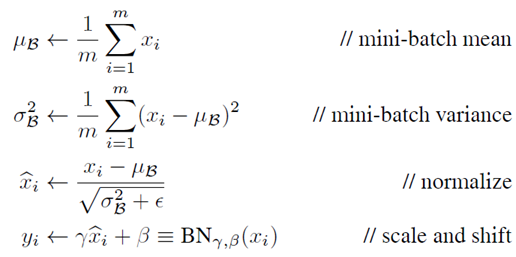

Where $x_i$ denotes the activations of aneuron on the $i$-th example in the minibatch.

The scale $\gamma$ and shift $\beta$ parameters are trainable and allow the unit to control the mean and magnitude of its outputs.

Please note that Batch Normalization ties the examples that belong to the same minibatch: it normalizes the output of neurons over the minibatch. This raises some issues:
- Durning evaluation we would prefer that each sample is evaluated regardless of the other ones in the minibatch. This is typically achieved by collecting the shift and scale constants $\mu_B$ and $\sigma_B^2$ on the trainig set, and then using them on the test set. Often, they are estmated as a running mean of the values seen durning training. In this way, during evaluation the examples in a minibatch are independent from each other.
- If training examples in a minibatch share some characteristic, chances are that batch normalization will remove its influence. Suppose for instance, that in a speech recognition system a minibatch is formed from utterances of a single speaker. The speaker information is present in all examples in the minibatch and may be removed by batch norm. 

  This inter-dependency between examples in the same mini-batch can be sometimes used for domain adaptation (e.g. to adapt the system to a new speaker). However, quite often it is introduced by mistake, simply due to insufficient shuffling of the training data. Watch out!

Batch normalization primarily helps network training, because it enforces proper scale of values. It often allows using larger learning rates, and with proper tuning can lead to faster convergence.

However, the minibatch statistics $\mu_B, \sigma_B$ are fairly noisy. Thus it introduces noise during trainign, which can also serve as a regularization.

Finally, please note that batch normalizatoin applied to the network's inputs can replace input normalization.

#### Other normalization schemes

Batch normalization chooses to standardize neuron's minibatch-wide statistics. However, we can often normalize across other dimensions:
- we can normalize the magnitudes of all neurons in a given layer
- on image data, the tensors often have shape `batch` $\times$ `channels` $\times$ `width` $\times$ `heigth`. Likewise, we often have a temporal dimension of the data. We can enforce normalization across any dimension:

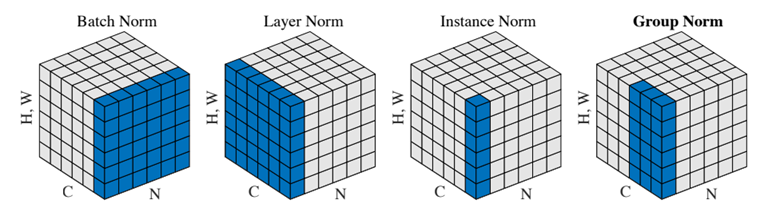

The alternative normalization schemes are attractive becasue they often fork similarly well as batch norm, but do not have the disadvantage of coupling together examples in a minibtach.

## Helping gradients flow

One problem found during training of deep networks is that the backpropagated gradient becomes very small. 

This effectively means that the relation between chenges to network parameters and the loss is lost, and successful traiing is not possible.

Popular solutions aim to remove situations in which the gradient is zeroed.


### Activation function saturation

One source of gradient vanishing is saturation of the sigmoids. Recall that the gradient is 
$$
\frac{\text{change of output}}{\text{change of input}}
$$

When the activatoin function is saturated, large changes in input lead to tiny changes of output and gradient stops being back-propagated.

The typical solution is to use non-linearities which do not saturate, at least on one extreme. Thus the logistic sigmoid and tanh activation, popular in the 1990s are replaced by ReLU and its variants.

However, the ReLU also saturates - it clips all negative values to 0. Thus practitioners are experimenting with so-called leaky ReLU, or even its non-monotonic variants:

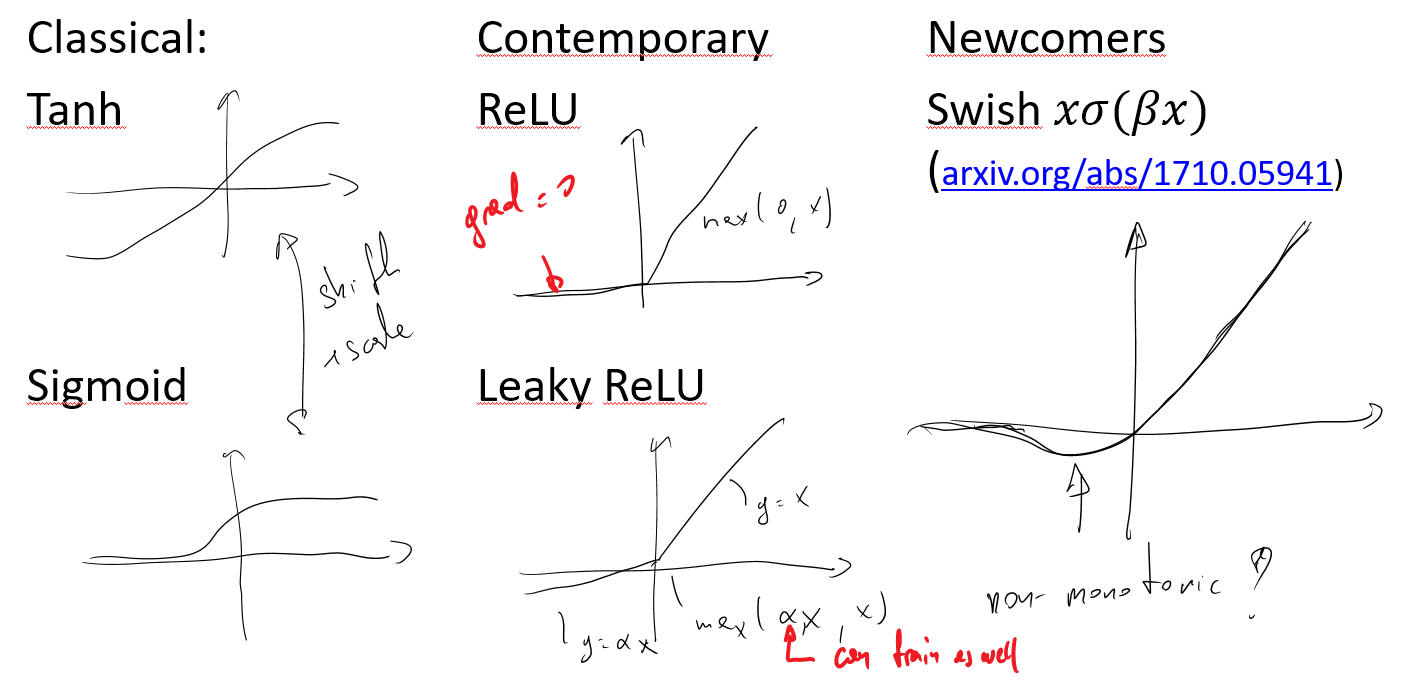

### Residual connections

The ultimate non-saturating activation function is the identity. Of course, we can't use it (without non-linear activations the network would behave like a linear model). The idea behind residual connection is the treat layer outputs as an additive correction of their inputs, rather than replacements.

A classical layer computes $o = f(x)$. In contrast a residual layer computes $o = x + f_r(x)$. Of course, nothing prevents $f_r$ from learning to behave like $-x$. However, especially at the beginning of network training, the residual layer conserves the gradient during backpropagation:

$$
\begin{split}
o &= x + f_r(x) \\
\frac{\partial o}{\partial x} &= 1 + \frac{\partial f_r}{\partial x}
\end{split}
$$

The use of residual layers has paved the road to trainign networks with hundreds of layers from scratch!

A residual network typically uses several blok which bypass a few layers with a residual connection:

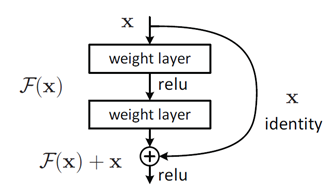

A residual network can be failry deep, e.g. 

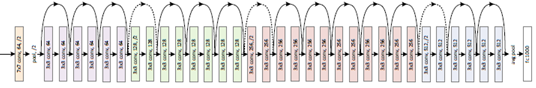

When BatchNorm is used in residual blocks, it is usually applied right after multiplications by the weigth matrices, but before the nonlinearities.

## Monitoring the training process

With proper initialization, residual connections and modern learning rules very deep networks can reliably be trained.

However, the process has to be tuned and thus we often plot several values during network training. The most important are:
- train and developmentvalidation losses
- train and developmentvalidation acurracies

Often we also inspect
- layer-wise weigth magnitudes
- gradient magnitudes
- activation funtion statistics (e.g. the fraction of neurons that never change value).

In a healthy trainig run the losses oscillate a bit between minibatches (minibatches are small and the loss is noisy). However, the mean training loss should monotonically decrease.

The validation/developement loss decreases for a while, then may start to increase, indicating the onset of overfitting. It often happens, that even though the validation loss is increasing, the error rate is still improving. This is usually caused by network confidence: it starts to make fewer, but more confident (hence more costly) mistakes.

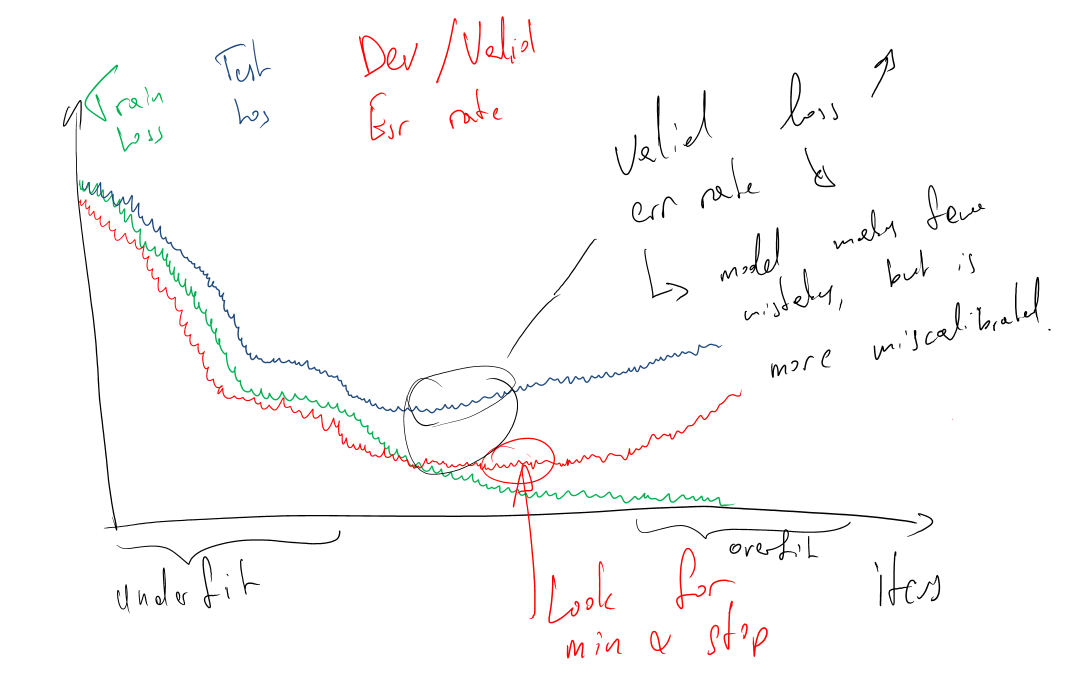

Monitoring network performance over trainign iterations allows stpooing training when the network stops to improve on a validation set. 

This is a nearly free and very effective strategy to choose the number of trainign iterations. It is called `early stopping`. Recall that our ultimatee goal is to perform well on unseen test data and not to fit the training set with the lowest possible error.

Monitoring the velidation loss or error rate, and stopping when it stops to improve helps us to choose a point before overfitting.

This point if often chosen using a patience-base approach. We do an initial number of iterations, expanding the amount of iterations by a percentage after each improvement of a development set statistic. E.g. one may choose to extend the number of iterations by 1.5 times each time the developmnet error decreases.

The patience-based strategy can also be used to choose moments when the learning rate is lowered.

## Distributed and large batch training

Neural networks can make efficient use of parallel hardware, and are typically implemented on GPUs. However, the desire to train large networks in a short time has led to strategies for multi-GPU and multi-node training of neural networks.

Multiple GPUs or nodes can be used to
1. Train models which do not fit on a singe node. In this case the model is partitioned across devices, and a single forward and backward pass occupies all devices.

2. Train models faster by splitting the data across several devices.

The first approach (split the model onto many devices) requires careful model design. For instance, the original "AlexNet" network for imagenet was designed to run on 2 GPUs: the image was processed independently by two GPUs, which exchanged activations every few layers.

In the second approach it is possible to do a forward and backward pass on a single device. We then aim to proces updates on a large number of training instances. Again, there are two possibilities of implementation:
- During an asynchronous SGD run, model weights are stored on a _paremeter server_. There are several worker nodes. Each worker node fetches parameters, runs a forward and backward pass, then sends the update to the parameter server. The parameter server applies the update (adds a change to the weights) asynchronously - other workers are dping computations using outdated weights. Quite surprisingly this works, acting a little like additional momentum: the updates are always a little stale, similarly the momentum method can be interpreted to perform updates based on gradients computed on past minibatches. This trainng regime was popular e.g. for language models whose weight matrices contained large tables with vector representations of each word: a single minibatch used only some of these embedings, yielding sparse updates.

- In contrast, during a synchronous SGD run, a large minibatch is split across several devices. All devices process their share of data, then gradients are added and and a joint update is applied. With the exception of e.g. Batch Normalization, which is usually applied per-device, this is conceptually equivalent to running the model on a large miniatch on a single large device.

Currently, the synchronous SGD approacn seems to have the upper hand, delivering final model performance close to minibatch regular SGD with good scaling over many devices. We direct the interested reader to the description of parallelizing training of ImageNet models: https://arxiv.org/abs/1706.02677. The rules of thumb to apply are:
- scale the learnign rate linearly with the number of devices. The intuition is that the larger the minibatch, the more stable the gradient estimate, and in consequence larger steps can be taken
- use learnign rate warmup, to allow training with the resulting large learning rate.


## Conclusions

While training deep neural networks is harder than training wide and shallow ones, with careful initialization, normalization, and residual connections it can be reliably performed. However, it requires some skill in setting all hyperparameters. 

Monitoring trainign dynamics is important, and very frequently we talk about "babysitting" trainig in which we not only look atht he end results of the network, but also at the evolution of the network performance over time.

### Further reading

- Goodfellow et al. "Deep Learning", https://www.deeplearningbook.org/ chapter 8
- Y. LeCun, "Efficient bckprop", http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf
- Y. Bengio „Practical Recommendation for Gradient-Based Training of Deep Architectures”, https://arxiv.org/pdf/1206.5533v2.pdf
- G. Hinton's lecture notes: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf 
- L. Bottou "Stochastic Gradient Descent Tricks", https://www.microsoft.com/en-us/research/publication/stochastic-gradient-tricks/?from=https%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F192769%2Ftricks-2012.pdf
- Slides from stanford about "babysitting neural networks":
    - http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf 
    - http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture7.pdf 
